# Iris Data Set - Quantum Neural Network

This notebook will showcase the usage of Tensorflow and Cirq to run binary classification with Quantum Computing. 
The data set used in this notebook is Iris Data Set.

## Requirements

The requirements for running this notebook are the following:

* Python 3.6 or later
* Cirq
* Tensorflow
* Tensorflow-Quantum
* Pandas



```
    pip install cirq
    pip install -q tensorflow==2.1.0
    pip install tensorflow-quantum
    pip install pandas
    pip install -U scikit-learn
```



## Iris Data Set 

For testing Tensorflow + Cirq we'll run a version of the [MNIST] experiment by Google. 
In this experiment, a similar approach than [Farhi et al] is executed over the MNIST data set. 

For our personal experiment we'll perform a classical classification problem: The [Iris Data Set].

This data set contains 4 features:
* Sepal length in cm
* Sepal width in cm
* Petal length in cm
* Petal width in cm

In order to simplify the problem, we'll transform this problem in a binary classification for Iris Setosa.



   [MNIST]: https://www.tensorflow.org/quantum/tutorials/mnist
   [Farhi et al]: https://arxiv.org/pdf/1802.06002.pdf
   [Iris Data Set]: https://archive.ics.uci.edu/ml/datasets/iris
   [Tensorflow]: https://www.tensorflow.org/

## Step 1. Ingestion of data set


In [1]:
# Libraries needed :
# 1. Pandas for data manipulation

import pandas as pd

# 2. SKLearn for data processing and training/test sets splitting.

from sklearn import preprocessing
from sklearn.model_selection import train_test_split

# 3. Cirq Libraries and SVGCircuit to show the circuits.

import cirq
from cirq.contrib.svg import SVGCircuit

# 4. Numpy to work with arrays of binary features

import numpy as np

# 5. Tensorflow and Tensorflow Quantum for the neural networks

import tensorflow as tf
import tensorflow_quantum as tfq

# 6. Sympy is a Python library for symbolic mathematics

import sympy

In [2]:
# File with our data set
data='data/iris_data.csv'

# Headers for the iris_data provided in iris.names: 
# Sepal Length, Sepal Width, Petal Length, Petal Width, Type of Iris
headers=["sl","sw","pl","pw","iris"]

In [3]:
iris_data=pd.read_csv(data, names=headers)

In [4]:
iris_data.head()

,sl,sw,pl,pw,iris
0,5.1,3.5,1.4,0.2,Iris-setosa
1,4.9,3.0,1.4,0.2,Iris-setosa
2,4.7,3.2,1.3,0.2,Iris-setosa
3,4.6,3.1,1.5,0.2,Iris-setosa
4,5.0,3.6,1.4,0.2,Iris-setosa


## Step 2. Process the data 
Transform the data to a binary classification problem. 
To do this, We'll transform the class into Iris-Setosa and Non Iris-Setosa. 

In [5]:
iris_data["iris_setosa"]=iris_data["iris"]=="Iris-setosa"

In [6]:
# Now we have a new column with the boolean depending if the flower is an Iris Setosa or not.
iris_data.head()

,sl,sw,pl,pw,iris,iris_setosa
0,5.1,3.5,1.4,0.2,Iris-setosa,True
1,4.9,3.0,1.4,0.2,Iris-setosa,True
2,4.7,3.2,1.3,0.2,Iris-setosa,True
3,4.6,3.1,1.5,0.2,Iris-setosa,True
4,5.0,3.6,1.4,0.2,Iris-setosa,True


In [7]:
# After the transformation of the data set, 33% of the population belongs to Iris Setosa, meanwhile 66% dont.
iris_data["iris_setosa"].value_counts()

False    100
True      50
Name: iris_setosa, dtype: int64

In [8]:
# The column iris is not needed anymore
iris_data.drop(columns=['iris'], inplace=True)

In [9]:
# The next step is to transform each value to a range of [0,1]

iris_values = iris_data.values
min_max_scaler = preprocessing.MinMaxScaler()
iris_values_scaled = min_max_scaler.fit_transform(iris_values)

iris_data_scaled = pd.DataFrame(iris_values_scaled, columns=["sl","sw","pl","pw","iris-setosa"])


In [10]:
iris_data_scaled.head()

,sl,sw,pl,pw,iris-setosa
0,0.222222,0.625000,0.067797,0.041667,1.0
1,0.166667,0.416667,0.067797,0.041667,1.0
2,0.111111,0.500000,0.050847,0.041667,1.0
3,0.083333,0.458333,0.084746,0.041667,1.0
4,0.194444,0.666667,0.067797,0.041667,1.0


In [11]:
# Prior splitting the data set, we'll get the features and the labels apart
feature_columns=['sl','sw','pl','pw']
label_columns=['iris-setosa']

iris_features=iris_data_scaled[feature_columns].copy()
iris_labels=iris_data_scaled[label_columns].copy()

In [12]:
# As final pre-transformation step, we'll split our data set in Train and Test
# As our set has only 33% of iris-setosa, we'll use stratify to ensure our train and test sets has a real
# representation of the population

iris_features_train, iris_features_test, iris_labels_train, iris_labels_test = train_test_split(iris_features, iris_labels, stratify=iris_labels, test_size=0.40, random_state=42)

In [13]:
# Once the full data set is scaled, we transform it to a binary encoding

THRESHOLD = 0.5

iris_features_train_bin = np.array(iris_features_train > THRESHOLD, dtype=np.float32)
iris_features_test_bin = np.array(iris_features_test > THRESHOLD, dtype=np.float32)

## Step 3. Transform Data to Quantum Data (in Quantum Circuit)

In [14]:
# To transform the data to our Quantum Circuit we'll adapt the function used in the MNIST example
def convert_to_circuit(member):
    """Encode truncated classical member info into quantum datapoint."""
    qubits = cirq.GridQubit.rect(1, 4)
    circuit = cirq.Circuit()
    for i, value in enumerate(member):
        if value:
            circuit.append(cirq.X(qubits[i]))
    return circuit


iris_train_circ = [convert_to_circuit(x) for x in iris_features_train_bin]
iris_test_circ = [convert_to_circuit(x) for x in iris_features_test_bin]

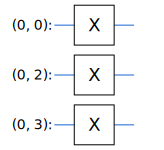

In [15]:
SVGCircuit(iris_train_circ[1])

In [16]:
iris_test_circ[6]

(0, 2): ───X───

(0, 3): ───X───

## Step 4. Transform Quantum Circuits to Tensors

In [17]:
# Convert the circuits to tensors we'll use in our neural networks
iris_features_train_tfcirc = tfq.convert_to_tensor(iris_train_circ)
iris_test_tfcirc = tfq.convert_to_tensor(iris_test_circ)

In [18]:
# For building our Quantum Neural Network, we'll base our code in the example of Tensorflow team at:
# https://www.tensorflow.org/quantum/tutorials/mnist 
#
# << There is little guidance for a quantum circuit structure that classifies images. 
#    Since the classification is based on the expectation of the readout qubit, Farhi et al. 
#    propose using two qubit gates, with the readout qubit always acted upon. 
#    This is similar in some ways to running small a Unitary RNN across the pixels. >>
#
# As we have adapted our experiment, we'll run an adapted process from the tutorial for classifying the iris dataset

class CircuitLayerBuilder():
    def __init__(self, data_qubits, readout):
        self.data_qubits = data_qubits
        self.readout = readout
    
    def add_layer(self, circuit, gate, prefix):
        for i, qubit in enumerate(self.data_qubits):
            symbol = sympy.Symbol(prefix + '-' + str(i))
            circuit.append(gate(qubit, self.readout)**symbol)



In [19]:
# Now build a two-layered model, matching the data-circuit size, and include the preparation and readout operations.

def create_quantum_model():
    """Create a QNN model circuit and readout operation to go along with it."""
    data_qubits = cirq.GridQubit.rect(1, 4)  # a 1x4 grid.
    readout = cirq.GridQubit(-1, -1)         # a single qubit at [-1,-1]
    circuit = cirq.Circuit()
    
    # Prepare the readout qubit.
    circuit.append(cirq.X(readout))
    circuit.append(cirq.H(readout))
    
    builder = CircuitLayerBuilder(
        data_qubits = data_qubits,
        readout=readout)

    # Then add layers (experiment by adding more).
    builder.add_layer(circuit, cirq.XX, "xx1")
    builder.add_layer(circuit, cirq.ZZ, "zz1")

    # Finally, prepare the readout qubit.
    circuit.append(cirq.H(readout))

    return circuit, cirq.Z(readout)

In [20]:
# Get our model circuit
model_circuit, model_readout = create_quantum_model()

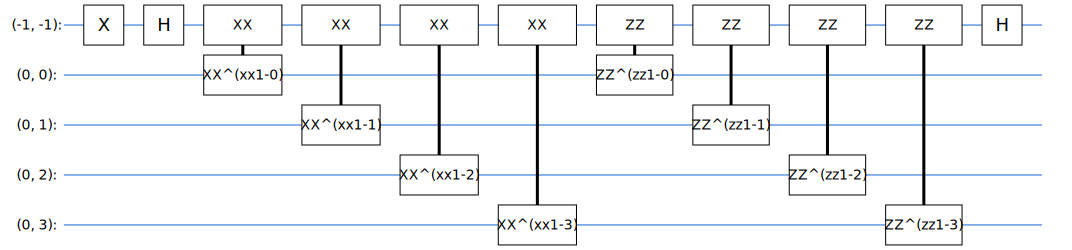

In [21]:
# Lets give it a look to how our circuit looks
SVGCircuit(model_circuit)

## Step 5. Build our model

In [22]:
# Build the Keras model.

model = tf.keras.Sequential([
    # The input is the data-circuit, encoded as a tf.string
    tf.keras.layers.Input(shape=(), dtype=tf.string),
    # The PQC layer returns the expected value of the readout gate, range [-1,1].
    tfq.layers.PQC(model_circuit, model_readout),
])

In [23]:
# To use this model we'll need to transform the labels from Boolean to [-1,1]
# Easy transfomration:

iris_labels_train_hin = 2.0*iris_labels_train-1.0
iris_labels_test_hin = 2.0*iris_labels_test-1.0

In [24]:
# Next part of our model to adapt is the hinge function as we need a metric that works with [-1,1]
def hinge_accuracy(y_true, y_pred):
    y_true = tf.squeeze(y_true) > 0.0
    y_pred = tf.squeeze(y_pred) > 0.0
    result = tf.cast(y_true == y_pred, tf.float32)

    return tf.reduce_mean(result)

In [25]:
# Finally we compile our model and take a look to what it looks
model.compile(
    loss=tf.keras.losses.Hinge(),
    optimizer=tf.keras.optimizers.Adam(),
    metrics=[hinge_accuracy])

In [26]:
# Quick summary of our model
print(model.summary())

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
pqc (PQC)                    (None, 1)                 8         
Total params: 8
Trainable params: 8
Non-trainable params: 0
_________________________________________________________________
None


## Step 6. Train our model

In [27]:
# This model may take some time. 
# Using these variables we can adapt the size of the set we'll use for training (just for showcase purposes)

EPOCHS = 10
BATCH_SIZE = 32

NUM_EXAMPLES = len(iris_features_train_tfcirc)

In [28]:
# Get a subset of our sets just in case we just want to showcase the model
# Otherwise use the full length of the set (as I did in the cell before with the len)
iris_train_tfcirc_sub = iris_features_train_tfcirc[:NUM_EXAMPLES]
iris_labels_hinge_sub = iris_labels_train_hin[:NUM_EXAMPLES]

In [ ]:
# Final step, we train our model and check how it looks
qnn_history = model.fit(
      iris_train_tfcirc_sub, iris_labels_hinge_sub,
      batch_size=BATCH_SIZE,
      epochs=EPOCHS,
      verbose=1,
      validation_data=(iris_test_tfcirc, iris_labels_test_hin))

qnn_results = model.evaluate(iris_test_tfcirc, iris_labels_test_hin)

Train on 90 samples, validate on 60 samples
Epoch 1/3
90/90 [==============================] - 2s 26ms/sample - loss: 1.0562 - hinge_accuracy: 0.3494 - val_loss: 0.9817 - val_hinge_accuracy: 0.4688
Epoch 2/3
90/90 [==============================] - 0s 1ms/sample - loss: 1.0497 - hinge_accuracy: 0.4327 - val_loss: 0.9774 - val_hinge_accuracy: 0.4688
Epoch 3/3
32/90 [=========>....................] - ETA: 0s - loss: 1.0662 - hinge_accuracy: 0.4375